# Easy Time Series Anomaly Detection 
# DEMO: Anomaly detection with DARTS forecasters

This notebook demonstrates the use of the __Easy Time Series Anomaly Detection__ framework.

The framework allows to use anomaly detectors from different libraries with a common interface.

Currently integrated libraries in the framework: 
* ADTK: https://adtk.readthedocs.io/en/stable/
* DARTS: https://unit8co.github.io/darts/
* RUPTURES: https://centre-borelli.github.io/ruptures-docs/




In [1]:

import sys
import pandas as pd

# Make the src directory visible  ---------
sys.path.append('../src')
#------------------------------------------


from base_anomaly_detector import read_yaml
import adtk_anomaly_detector as aad
import ruptures_change_point_detector as rcpd
import darts_forecasting_anomaly_detector as dfad




The StatsForecast module could not be imported. To enable support for the AutoARIMA, AutoETS and Croston models, please consider installing it.
The `XGBoost` module could not be imported. To enable XGBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `XGBoost` module could not be imported. To enable XGBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


### 1. Load the example data

In this example, we load an electrical time series (hourly power) with ground truth labels.

Columns:
* timestamp
* value
* label


In [2]:
data_filename = '../data/energy_2021_2024_1hour.csv'
df = pd.read_csv(data_filename, parse_dates=['timestamp'], index_col='timestamp')
df

,value,label
timestamp,,
2021-01-01 00:00:00,3.086733,0
2021-01-01 01:00:00,2.919535,0
2021-01-01 02:00:00,2.855228,0
2021-01-01 03:00:00,2.688030,0
2021-01-01 04:00:00,2.546555,0
...,...,...
2024-06-30 19:00:00,4.936271,0
2024-06-30 20:00:00,5.101325,0
2024-06-30 21:00:00,5.112758,0


The same series will be used for train, validation and test. But different time intervals will be defined in the configuration 

In [3]:
train_val_data = df[['value']]
test_data = df[['value']]
known_anomalies_data = df[['label']]


## 2. Load the configuration

Load a configuration.  
The configuration in this case defines an anomaly detector using a DARTS regression forecaster.



In [4]:
config = read_yaml('../config/config_darts_regression_forecaster.yaml')
config

{'darts': {'forecasting_model': {'class': 'SKLearnModel',
   'parameters': {'lags': 168,
    'lags_future_covariates': (168, 0),
    'lags_past_covariates': 168,
    'output_chunk_length': 1,
    'add_encoders': {'cyclic': {'past': ['hour', 'dayofweek'],
      'future': ['hour', 'dayofweek']}}}},
  'anomaly_scorer': {'class': 'WassersteinScorer',
   'parameters': {'window': 24, 'component_wise': False, 'window_agg': True}},
  'anomaly_detector': {'class': 'QuantileDetector',
   'parameters': {'high_quantile': 0.95}},
  'anomaly_model': {'class': 'ForecastingAnomalyModel',
   'fit_parameters': {'start': 0,
    'allow_model_training': False,
    'verbose': True}}},
 'timestamps': {'train': {'start': '2021-01-01 00:00:00',
   'end': '2021-04-30 23:59:59',
   'freq': 'H'},
  'val': {'start': '2021-05-01 00:00:00',
   'end': '2021-08-31 23:59:59',
   'freq': 'H'},
  'test': {'start': '2021-09-01 00:00:00',
   'end': '2021-11-30 23:59:59',
   'freq': 'H'}},
 'logging': {'level': 'INFO', 'fil

## Create the detector
Create the detector with the configuration and datasets

In [5]:
detector = dfad.DartsForecastingAnomalyDetector(config, train_val_data, test_data, known_anomalies_data, "Energy TS")

Show all the datasets

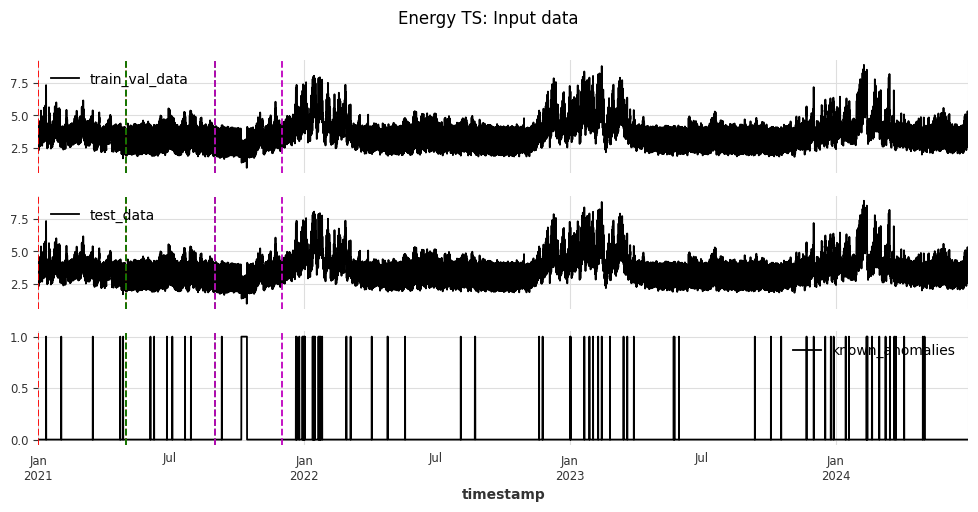

In [6]:
detector.plot_data(all_data=True)

Plot only the intervals defined in the configuration 

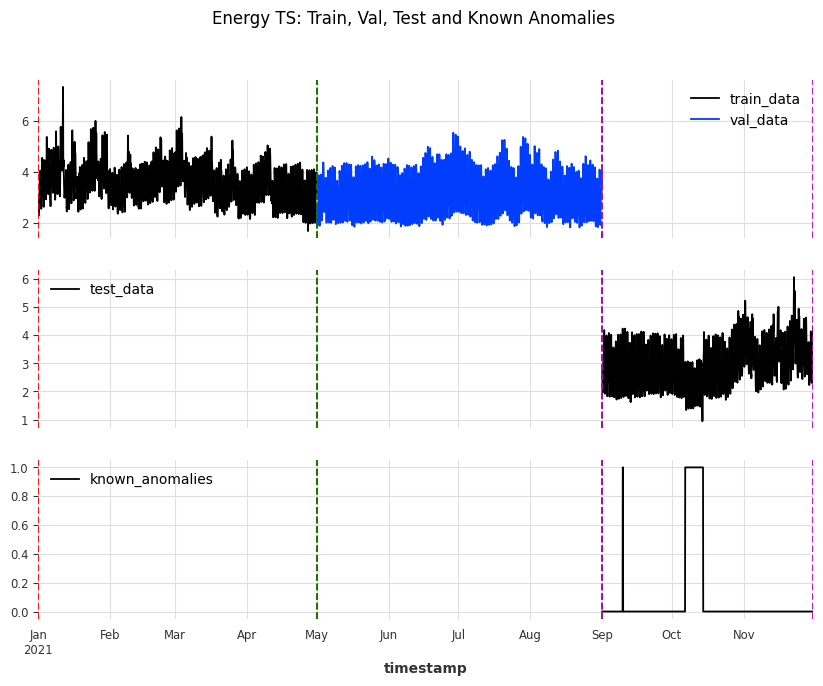

In [7]:
detector.plot_data(all_data=False)

## Training

In [8]:
detector.fit()

historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

## Scores

Scores in the validation set

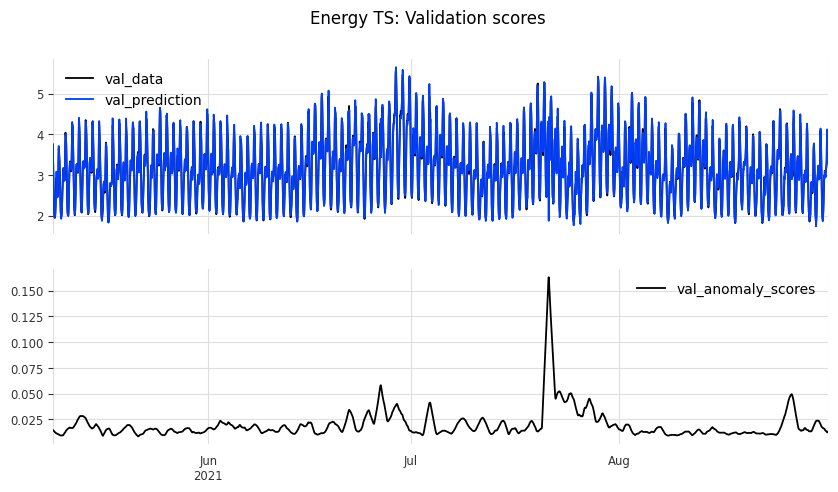

In [9]:
val_scores = detector.get_val_scores(plot=True)

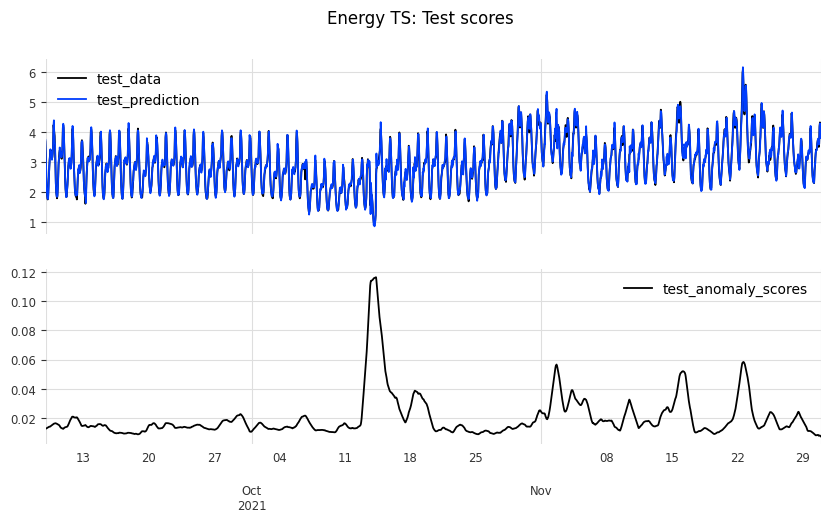

In [10]:
test_scores = detector.get_test_scores(plot=True)

Detect anomallies on the test set. 
Assuming that the train and val sets are "normal", we can set anomalies to the scores in test that are above the scores in val.

But val data is not clean in this case. We set here a threshold to the percentile 95 in test.

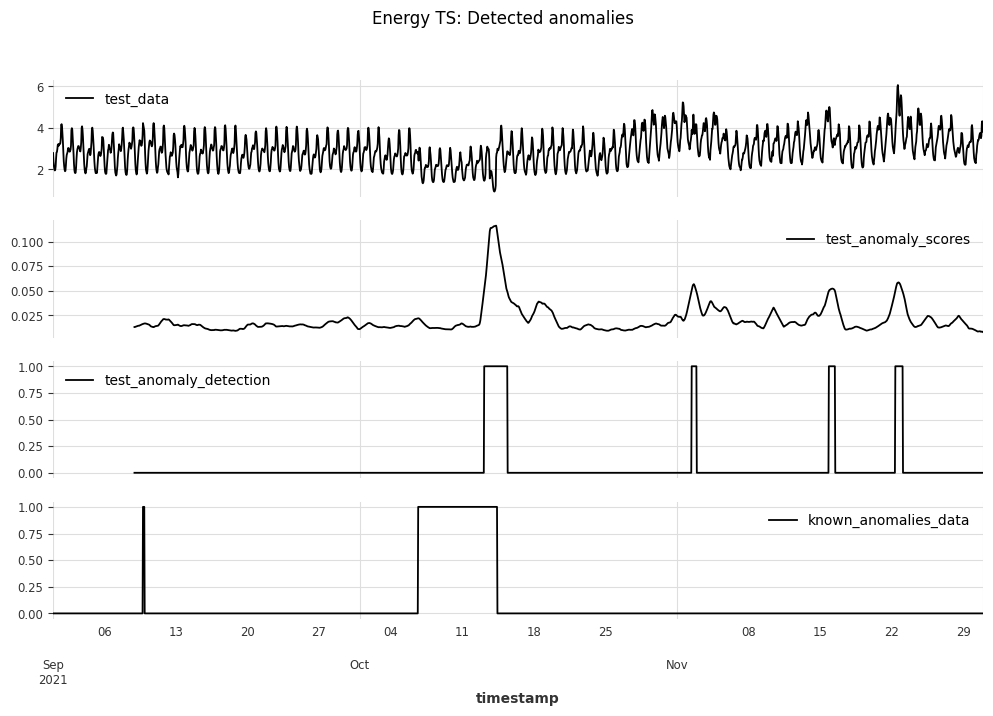

In [11]:
test_anomaly_detection = detector.get_test_anomaly_detection(plot=True, 
                                    thresholding='test_percentile',
                                    percentile=0.95,
                                    recompute=False
                                    )



## Detection with a new forecaster of the DARTS library

Let us load another configuration where we only change the forecaster. 
The new forecaster is based on Temporal Convolution Networks

In [12]:
config_tcn = read_yaml('../config/config_darts_tcn_forecaster.yaml')
config_tcn

{'darts': {'forecasting_model': {'class': 'TCNModel',
   'parameters': {'input_chunk_length': 168,
    'output_chunk_length': 1,
    'n_epochs': 10,
    'dropout': 0.1,
    'batch_size': 32,
    'optimizer_kwargs': {'lr': 0.001},
    'pl_trainer_kwargs': {'accelerator': 'gpu'},
    'kernel_size': 21,
    'num_filters': 8,
    'model_name': 'TCN_test',
    'save_checkpoints': True,
    'log_tensorboard': True,
    'force_reset': True,
    'random_state': 42,
    'add_encoders': {'cyclic': {'past': ['hour', 'dayofweek'],
      'future': ['hour', 'dayofweek']}}}},
  'anomaly_scorer': {'class': 'WassersteinScorer',
   'parameters': {'window': 24, 'component_wise': False, 'window_agg': True}},
  'anomaly_detector': {'class': 'QuantileDetector',
   'parameters': {'high_quantile': 0.95}},
  'anomaly_model': {'class': 'ForecastingAnomalyModel',
   'fit_parameters': {'start': 0,
    'allow_model_training': False,
    'verbose': True}}},
 'timestamps': {'train': {'start': '2021-01-01 00:00:00',


Code does not change !

In [13]:
detector = dfad.DartsForecastingAnomalyDetector(config_tcn, train_val_data, test_data, known_anomalies_data, "Example_TCN")

In [14]:
detector.fit()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 6.5 K  | train
-------------------------------------------------------------
6.5 K     Trainable params
0         Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

/anomalias/home/gastong/anaconda3/envs/easy_ts_ad/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:388: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['train_loss', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


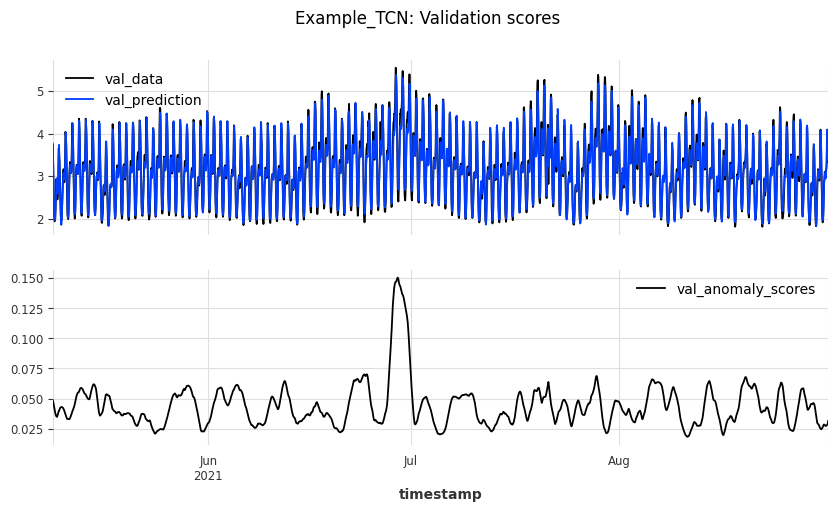

,value
timestamp,
2021-05-08 23:00:00,0.047872
2021-05-09 00:00:00,0.046573
2021-05-09 01:00:00,0.045200
2021-05-09 02:00:00,0.043777
2021-05-09 03:00:00,0.042497
...,...
2021-08-31 19:00:00,0.028204
2021-08-31 20:00:00,0.028422
2021-08-31 21:00:00,0.028693


In [15]:
detector.get_val_scores(plot=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


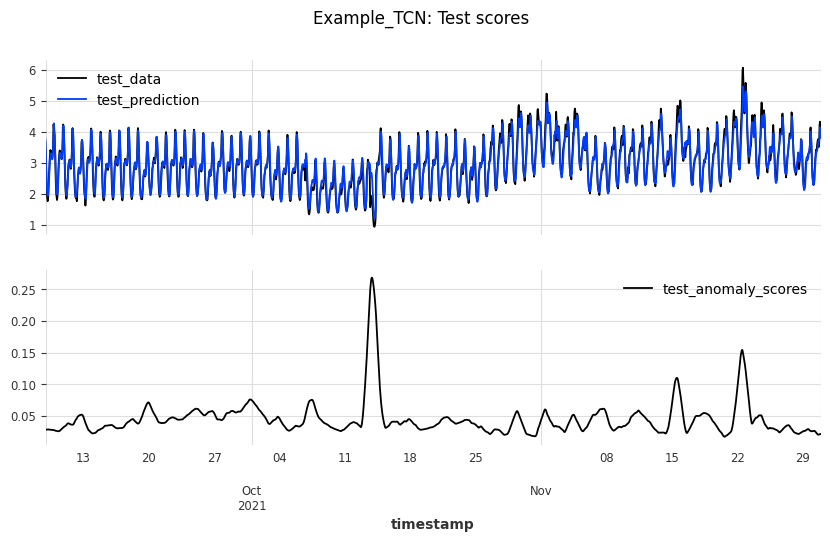

,value
timestamp,
2021-09-08 23:00:00,0.028166
2021-09-09 00:00:00,0.028572
2021-09-09 01:00:00,0.028773
2021-09-09 02:00:00,0.028832
2021-09-09 03:00:00,0.028885
...,...
2021-11-30 19:00:00,0.020939
2021-11-30 20:00:00,0.021225
2021-11-30 21:00:00,0.021560


In [17]:
detector.get_test_scores(plot=True)

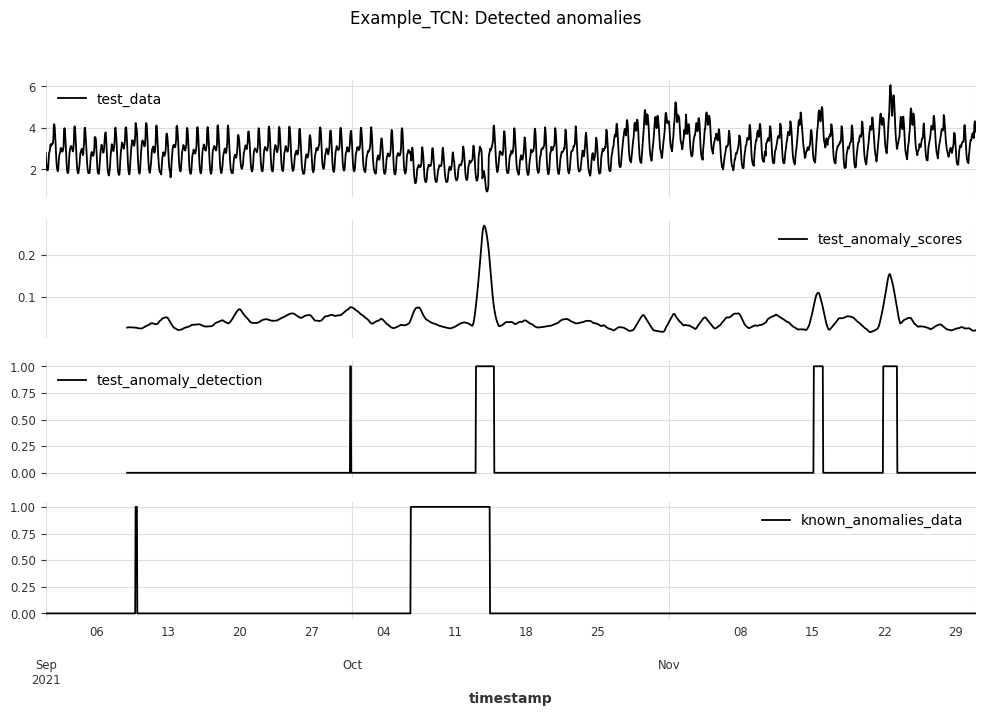

In [18]:
test_anomaly_detection = detector.get_test_anomaly_detection(plot=True, 
                                    thresholding='test_percentile',
                                    percentile=0.95,
                                    recompute=False
                                    )